In [1]:
import sys
sys.path.append('../../')

from amplify.client import FixstarsClient
from matplotlib import pyplot as plt
import numpy as np
import os
import tikzplotlib

from flow_solver.finite_element_model import FEM
from flow_solver.mesh_generator import MeshDiffuser
from optimizer import Annealing, AnnealingSolver
from problems.topo_opt_level_set_fluid_flow import TopologyOptimizationProblem

# Parameter Tuning for Diffuser Problem

In [2]:
output_path = '/usr2/key/Projects/QuantumAnnealing/TopoFlowManuscript/fig/parameter_study/diffuser/regularization'

In [3]:
textwidth_in_inches = 500.484/72.27

## Computational Mesh

In [4]:
# Create Meshes for Diffuser Problem
n_elem_for_width = 32
n_elem_for_height = 32

mesh_v = MeshDiffuser('Q2', n_elem_for_width, n_elem_for_height)
mesh_p = MeshDiffuser('Q1', n_elem_for_width, n_elem_for_height)

if n_elem_for_width < 5:
    mesh_v.plot()
    mesh_p.plot()

## Finite Element Model
### Boundary Conditions

In [5]:
def inlet_velocity(mesh, i_node):
    x = mesh.coords[i_node][0]; y = mesh.coords[i_node][1]
    v_x = 4*(1.-y)*y; v_y = 0.0
    return np.array([v_x, v_y])

In [6]:
# Compute boundary velocities.
boundary_velocity = {key: [] for key in mesh_v.boundary_nodes.keys()}
for boundary in mesh_v.boundary_nodes.keys():
    for i_node in mesh_v.boundary_nodes[boundary]:
        if boundary == 'inlet':
            boundary_velocity[boundary].append(inlet_velocity(mesh_v, i_node))
        elif boundary == 'wall':
            boundary_velocity[boundary].append(np.zeros(2))

# Set values for Dirichlet boundary conditions.
# Velocity.
BC = []
for boundary in mesh_v.boundary_nodes.keys():
    for i_node, node in enumerate(mesh_v.boundary_nodes[boundary]):
        if boundary == 'inlet' or boundary == 'wall' :
            BC.append([node, 0, boundary_velocity[boundary][i_node][0]])
            BC.append([node, 1, boundary_velocity[boundary][i_node][1]])
boundary_values_v = np.array(BC)

### Material Properties

In [7]:
viscosity = 1.0
density = 1.0

### Finite Element Model

In [8]:
fem = FEM(mesh_v, mesh_p, viscosity, density, epsilon=8.e-2)
fem.set_boudary_values_v(boundary_values_v)

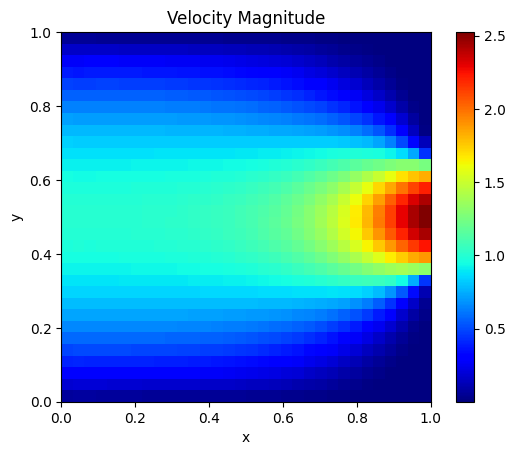

In [9]:
U, u_e, v_e, p_e, F, f = fem.solve()
fem.plot_velocity_magnitude([u_e, v_e])

## Optimization

In [10]:
# Settings for Optimization.
volume_fraction_max = 0.5 # Volume fraction.
level_set_scaled_initial = np.ones(mesh_v.n_elem) # Initial scaled level-set function, i.e., design variable, for each element.

In [11]:
# Annealing Solver.
client = FixstarsClient()
client.parameters.timeout = 1000
client.parameters.outputs.duplicate = True

if os.path.exists('token_Fixstars.txt'):
    client.token = open('token_Fixstars.txt',"r").read().replace('\n', '')
if os.path.exists('proxy.txt'):
    client.proxy = open('proxy.txt',"r").read().replace('\n', '')
    
annealing_solver = AnnealingSolver(client)

In [12]:
# Topology Optimization Problem
n_qubits_per_variable = 9
hyperparameters = {
    'energy_dissipation': 100.,
    'regularization': 1.,
    'volume_constraint': 20.,
    'char_func': 4.,
}
topo_opt_problem = TopologyOptimizationProblem(fem.ne, n_qubits_per_variable, hyperparameters, volume_fraction_max)
topo_opt_problem.generate_discretizaton()

In [13]:
# Annealing-Based Optimizer (Two-Step Optimization)
annealing_optimizer = Annealing(fem)
max_opt_steps = 10

## REGULARIZATION 0.25 ##
Iteration: 0, Objective Function: 0.025147014333733075, Volume Fraction: 0.513671875, Inconsistencies: 0
Abs. change in
	char. func.:498.0
Rel. change in
	char. func.:0.486328125
	Obj. func.: 7.945163875349022
Iteration: 1, Objective Function: 0.012224621958590205, Volume Fraction: 0.501953125, Inconsistencies: 0
Abs. change in
	char. func.:44.0
Rel. change in
	char. func.:0.08365019011406843
	Obj. func.: 0.5138738223013746
Iteration: 2, Objective Function: 0.01098180306250121, Volume Fraction: 0.5009765625, Inconsistencies: 0
Abs. change in
	char. func.:11.0
Rel. change in
	char. func.:0.021400778210116732
	Obj. func.: 0.10166522124765333
Iteration: 3, Objective Function: 0.010352884963958317, Volume Fraction: 0.5009765625, Inconsistencies: 0
Abs. change in
	char. func.:6.0
Rel. change in
	char. func.:0.011695906432748537
	Obj. func.: 0.05726911099784841
Iteration: 4, Objective Function: 0.010180459075754468, Volume Fraction: 0.5009765625, Inconsistencies: 0


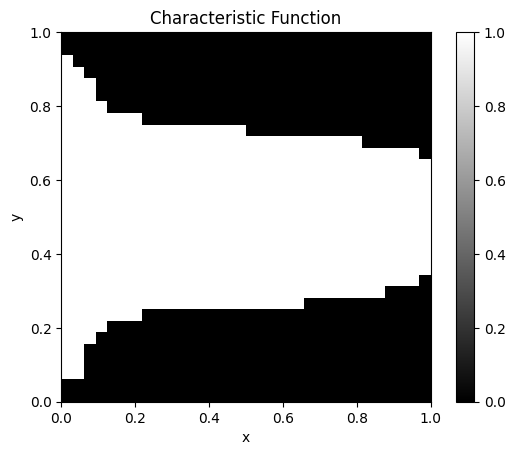

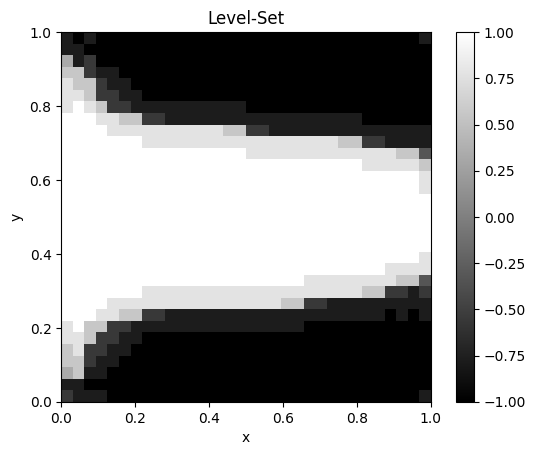

## REGULARIZATION 0.5 ##
Iteration: 0, Objective Function: 0.025147014333733075, Volume Fraction: 0.513671875, Inconsistencies: 0
Abs. change in
	char. func.:498.0
Rel. change in
	char. func.:0.486328125
	Obj. func.: 7.945163875349022
Iteration: 1, Objective Function: 0.012624532864236348, Volume Fraction: 0.501953125, Inconsistencies: 0
Abs. change in
	char. func.:42.0
Rel. change in
	char. func.:0.07984790874524715
	Obj. func.: 0.4979709043510043
Iteration: 2, Objective Function: 0.011288248529511647, Volume Fraction: 0.5009765625, Inconsistencies: 0
Abs. change in
	char. func.:11.0
Rel. change in
	char. func.:0.021400778210116732
	Obj. func.: 0.10584822021496099
Iteration: 3, Objective Function: 0.01048941762837433, Volume Fraction: 0.5009765625, Inconsistencies: 0
Abs. change in
	char. func.:8.0
Rel. change in
	char. func.:0.015594541910331383
	Obj. func.: 0.07076659404236886
Iteration: 4, Objective Function: 0.010211836496093078, Volume Fraction: 0.5009765625, Inconsistencies: 0
A

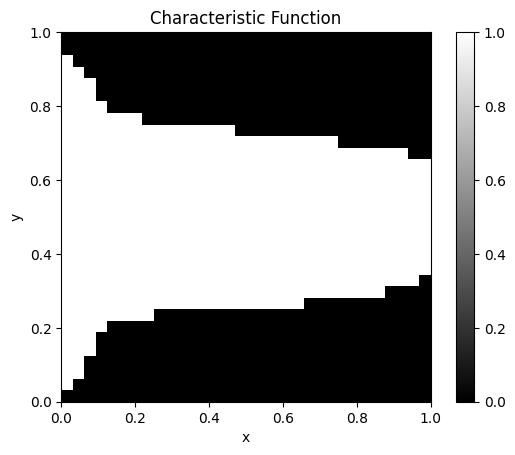

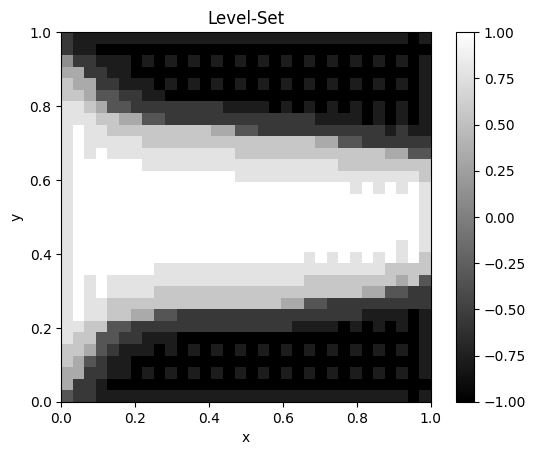

## REGULARIZATION 1.0 ##
Iteration: 0, Objective Function: 0.025147014333733075, Volume Fraction: 0.513671875, Inconsistencies: 0
Abs. change in
	char. func.:498.0
Rel. change in
	char. func.:0.486328125
	Obj. func.: 7.945163875349022
Iteration: 1, Objective Function: 0.012327688603776539, Volume Fraction: 0.501953125, Inconsistencies: 2
Abs. change in
	char. func.:44.0
Rel. change in
	char. func.:0.08365019011406843
	Obj. func.: 0.5097752583995726
Iteration: 2, Objective Function: 0.010752404547105996, Volume Fraction: 0.5009765625, Inconsistencies: 0
Abs. change in
	char. func.:13.0
Rel. change in
	char. func.:0.02529182879377432
	Obj. func.: 0.12778421870487228
Iteration: 3, Objective Function: 0.010447977770924745, Volume Fraction: 0.5009765625, Inconsistencies: 0
Abs. change in
	char. func.:4.0
Rel. change in
	char. func.:0.007797270955165692
	Obj. func.: 0.028312436985379937
Iteration: 4, Objective Function: 0.010186156571385717, Volume Fraction: 0.5009765625, Inconsistencies: 0


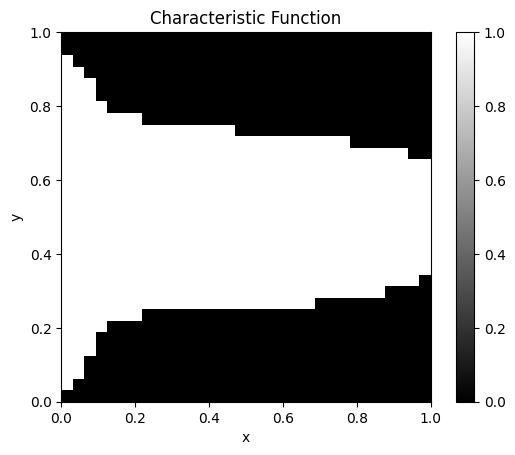

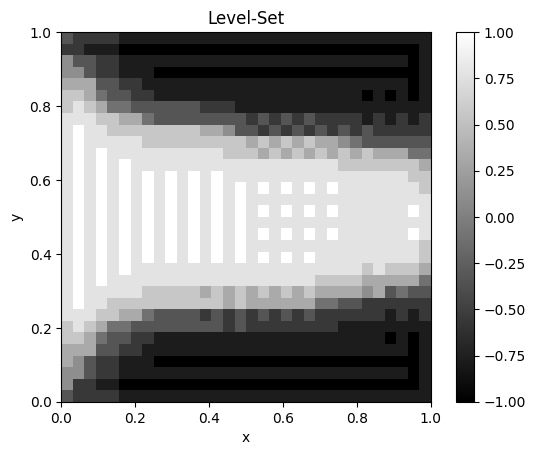

## REGULARIZATION 2.0 ##
Iteration: 0, Objective Function: 0.025147014333733075, Volume Fraction: 0.513671875, Inconsistencies: 0
Abs. change in
	char. func.:498.0
Rel. change in
	char. func.:0.486328125
	Obj. func.: 7.945163875349022
Iteration: 1, Objective Function: 0.01233393468276254, Volume Fraction: 0.501953125, Inconsistencies: 4
Abs. change in
	char. func.:44.0
Rel. change in
	char. func.:0.08365019011406843
	Obj. func.: 0.5095268758718058
Iteration: 2, Objective Function: 0.011183541064321359, Volume Fraction: 0.5009765625, Inconsistencies: 4
Abs. change in
	char. func.:11.0
Rel. change in
	char. func.:0.021400778210116732
	Obj. func.: 0.09327061055779141
Iteration: 3, Objective Function: 0.010494724080038932, Volume Fraction: 0.5009765625, Inconsistencies: 3
Abs. change in
	char. func.:6.0
Rel. change in
	char. func.:0.011695906432748537
	Obj. func.: 0.06159202888608746
Iteration: 4, Objective Function: 0.010202970540751652, Volume Fraction: 0.5009765625, Inconsistencies: 4
A

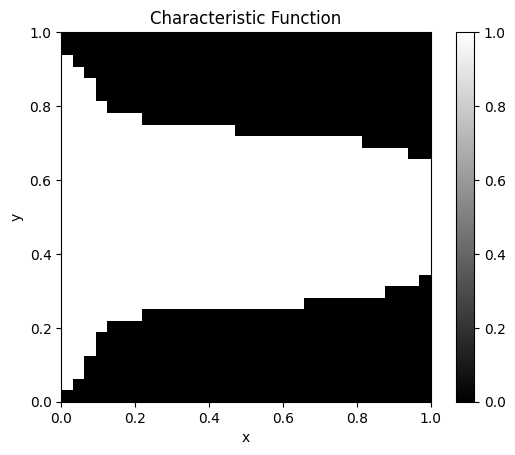

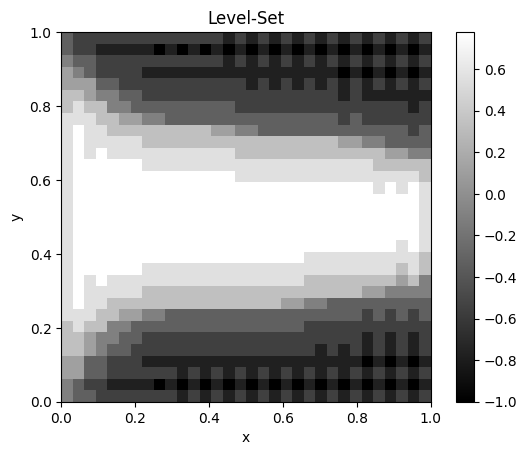

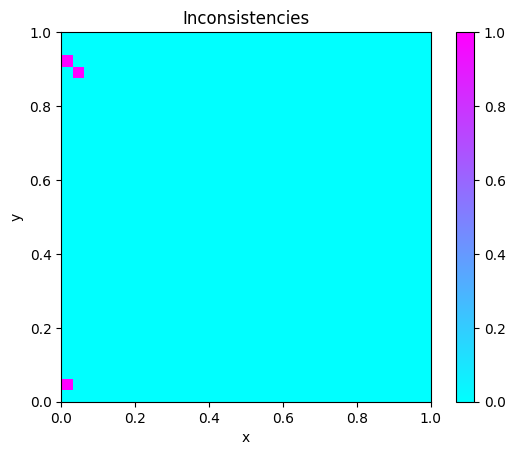

## REGULARIZATION 4.0 ##
Iteration: 0, Objective Function: 0.025147014333733075, Volume Fraction: 0.513671875, Inconsistencies: 2
Abs. change in
	char. func.:498.0
Rel. change in
	char. func.:0.486328125
	Obj. func.: 7.945163875349022
Iteration: 1, Objective Function: 0.01221155933482843, Volume Fraction: 0.501953125, Inconsistencies: 8
Abs. change in
	char. func.:44.0
Rel. change in
	char. func.:0.08365019011406843
	Obj. func.: 0.5143932725863435
Iteration: 2, Objective Function: 0.011133730519742473, Volume Fraction: 0.5009765625, Inconsistencies: 9
Abs. change in
	char. func.:11.0
Rel. change in
	char. func.:0.021400778210116732
	Obj. func.: 0.0882629961934423
Iteration: 3, Objective Function: 0.010422313925438798, Volume Fraction: 0.5009765625, Inconsistencies: 8
Abs. change in
	char. func.:8.0
Rel. change in
	char. func.:0.015594541910331383
	Obj. func.: 0.06389741453165067
Iteration: 4, Objective Function: 0.010104405663485694, Volume Fraction: 0.5009765625, Inconsistencies: 10
A

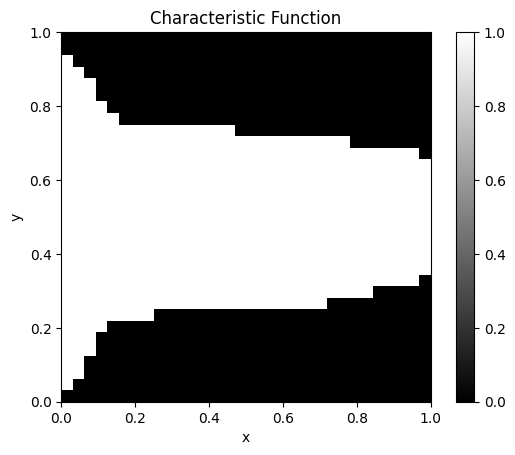

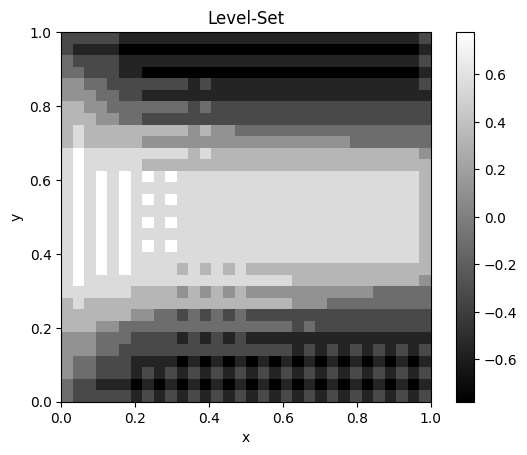

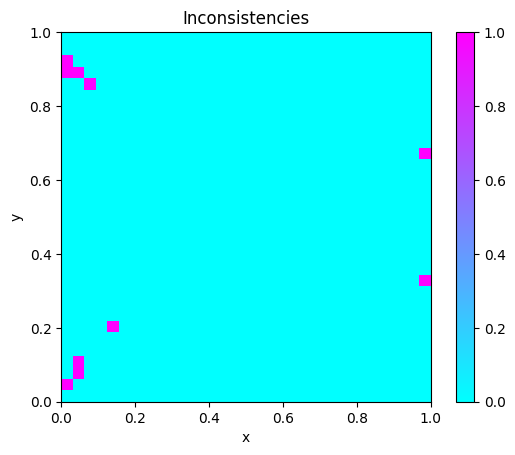

In [14]:
# Hyperparameter Study.

lambda_reg_initial = 0.5
lambda_reg_delta = 0.5
n_steps_reg = 5
lambda_reg_values = []
lambda_reg_values = [0.25, 0.5, 1.0, 2.0, 4.0]


objective_functions_values = []
volume_fraction_values = []
inconsistency_values = []
char_funcs = []
level_sets = []
for lambda_char_i in range(n_steps_reg):
    #hyperparameters['regularization'] = lambda_char_i * lambda_reg_delta
    hyperparameters['regularization'] = lambda_reg_values[lambda_char_i]
    lambda_reg_values.append(hyperparameters['regularization'])
    print(f"## REGULARIZATION {lambda_reg_values[-1]} ##")

    output_path_current = os.path.join(output_path, str(lambda_char_i))
    os.makedirs(output_path_current, exist_ok=True)

    topo_opt_problem.set_hyperparameters(hyperparameters)
    annealing_optimizer.optimize(annealing_solver, 
                                topo_opt_problem,
                                level_set_scaled_initial, 
                                max_opt_steps, tol=1e-2,
                                output_path=output_path_current,
                                tikz = True)
    objective_functions_values.append(annealing_optimizer.objective_function)
    volume_fraction_values.append(annealing_optimizer.volume_fraction)
    inconsistency_values.append(annealing_optimizer.n_inconsistencies)
    level_set, level_set_scaled, char_func = topo_opt_problem.get_functions_from_binary_solutions(annealing_optimizer.binary_solutions_optimum)
    char_funcs.append(char_func)
    level_sets.append(level_set)

